## Import Modules

In [1]:
import mediapipe as mp
import cv2
import time
import numpy as np
import pandas as pd
import os
from pathlib import Path
from random import randint
from typing import List
import pickle

import torch
from torch import nn

from torch.nn import functional as F

from yolox.data_augment import preproc
from yolox.yolox import YOLOX, get_model, IdentityModule

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

from skorch import NeuralNetClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt


import warnings
warnings.filterwarnings('ignore')

## 1. Load the dataset

### I. Baseline Model

In [24]:
# Preparation
mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils # For drawing keypoints
points = mpPose.PoseLandmark # Landmarks
path = "dataset/train/"
data = []
for p in points:
        x = str(p)[13:]
        data.append(x + "_x")
        data.append(x + "_y")
        data.append(x + "_z")
        data.append(x + "_vis")
data = pd.DataFrame(columns = data) # Empty dataset

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [25]:
# Creating Dataset
target = []
images_arrays = []
count = 0

for subdir, dirs, files in os.walk(path):
    for img in files:
        temp = []
        img = os.path.join(subdir, img)
        img = cv2.imread(img)

        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        blackie = np.zeros(img.shape) # Blank image
        results = pose.process(imgRGB)


        if results.pose_landmarks:
                mpDraw.draw_landmarks(blackie, results.pose_landmarks, mpPose.POSE_CONNECTIONS) # draw landmarks on blackie
                landmarks = results.pose_landmarks.landmark

                for i,j in zip(points,landmarks):
                        temp = temp + [j.x, j.y, j.z, j.visibility]
                data.loc[count] = temp
                target.append(subdir.replace(path, ''))
                count +=1


data['target'] = target

Premature end of JPEG file
Corrupt JPEG data: premature end of data segment


In [26]:
# Label Encoding for target
labelencoder = LabelEncoder()
data['target'] = labelencoder.fit_transform(data['target'])

In [27]:
# Displaying Dataset
data.head(5)

,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_vis,LEFT_EYE_x,LEFT_EYE_y,...,RIGHT_HEEL_vis,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis,target
0,0.365975,0.297709,-0.385955,0.999924,0.375471,0.288381,-0.355241,0.999899,0.381822,0.288810,...,0.728874,0.343049,0.770953,-0.013308,0.970696,0.373077,0.595134,0.249858,0.641886,3
1,0.517337,0.273278,-0.649164,0.999928,0.532713,0.258381,-0.619042,0.999905,0.540860,0.258364,...,0.696976,0.481968,0.983146,-0.157763,0.966885,0.516807,0.731737,0.358949,0.615583,3
2,0.493811,0.170744,-0.357681,0.999934,0.506060,0.155396,-0.318918,0.999913,0.513639,0.155501,...,0.695904,0.475992,0.930432,0.089517,0.966968,0.425618,0.903785,0.344804,0.643306,3
3,0.363192,0.253992,-0.522942,0.999566,0.375098,0.241423,-0.478249,0.999525,0.383550,0.241243,...,0.705867,0.357126,0.674954,0.499544,0.908316,0.388761,0.913819,0.144282,0.663821,3
4,0.402617,0.247819,-0.569452,0.998938,0.394126,0.238084,-0.583032,0.998867,0.396659,0.234638,...,0.721907,0.743622,0.945898,0.123149,0.913700,0.413644,0.941780,0.413074,0.692597,3


#### Exploratory Data Analysis

In [28]:
label_df = pd.DataFrame()
label_df['label'] = list(map(lambda x: labelencoder.inverse_transform([x])[0], data['target']))

bars = alt.Chart(label_df).mark_bar(size=50).encode(
    x=alt.X('label', axis=alt.Axis(title='Pose')),
    y=alt.Y("count()", axis=alt.Axis(title='Count')),
    tooltip=[alt.Tooltip('count()', title='Count'), 'label'],
    color='label'
)

(bars).interactive().properties(
    height=300, 
    width=700,
    title = "Number of data in each pose",
)


alt.Chart(...)

### II. Yolox Model

In [2]:
# YOLOX Configuration
class dotdict(dict):
    """
    Dotdict is just a dictionary whose elements can be referenced with a dot operation.
    I.e. dotdict['x'] == dotdict.x

    This is useful because the original YOLOX used a custom class to hold a lot of extra configuration that
    we do not need.
    """
    # def __getattr__(self, x):
    #     return self[x]


opt = dotdict()
# All images should be scaled to this input size before passing through YOLOX.
# Any image (of any size) can be scaled using the function `yolox.data_augment.preproc`
# I don't recommend changing this. This is just fine and loads pretty quickly, even on CPU.
opt.input_size = (640, 640)
opt.random_size = (10, 20)  # None; multi-size train: from 448(14*32) to 832(26*32), set None to disable it
opt.test_size = (640, 640)
opt.rgb_means = [0.485, 0.456, 0.406]
opt.std = [0.229, 0.224, 0.225]
opt.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
opt.backbone = "CSPDarknet-nano"
opt.depth_wise = True
opt.use_amp = False  # True, Automatic mixed precision

In [3]:
from yolox.data_augment import random_perspective
path = "dataset/train/"
# Creating Dataset
target = []
count = 0
num_transformations = 0

images_arrays = []
target = []

for subdir, dirs, files in os.walk(path):
    for img in files:
        temp = []
        img = os.path.join(subdir, img)
#         print(img)
        img = cv2.imread(img)
        
#         print('transformations')
        transformations = [img] + [random_perspective(img, scale=[0.5,1.2])[0] for _ in range(num_transformations)]
#         print('imgs')
        imgs = [preproc(imgx, opt.test_size, opt.rgb_means, opt.std)[0] for imgx in transformations]
#         img, r = preproc(img, opt.test_size, opt.rgb_means, opt.std)
        label = subdir.replace(path, '')
        
        
        images_arrays.extend(imgs)
        target.extend([label]*(len(imgs)))

print('stack')
# inp_imgs = np.zeros([len(images_arrays), 3, opt.test_size[0], opt.test_size[1]], dtype=np.float32)
# for b_i, image in enumerate(images_arrays):
#     inp_imgs[b_i] = image
inp_imgs = np.stack(images_arrays).astype(np.float32)



Premature end of JPEG file
Corrupt JPEG data: premature end of data segment


stack


In [4]:
inp_imgs.shape

(1081, 3, 640, 640)

In [5]:
# Label Encoding for target
labelencoder = LabelEncoder()
target = labelencoder.fit_transform(target)

# Shuffle them, otherwise our training gets all screwy
inp_imgs, target = shuffle(inp_imgs, target)

print(target)

[0 2 4 ... 1 4 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


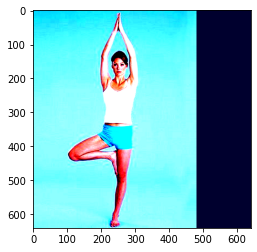

(3, 640, 640)


In [6]:
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

imshow(images_arrays[1])
print(images_arrays[1].shape)

## 2. Define a baseline model and your model

### I. Baseline Model

In [31]:
# Defining baseline model
X,Y = data.iloc[:,:132],data['target']
baseline_model = SVC(kernel = 'poly')

### II. YOLOX Model

In [7]:
# Load YOLOX (Including weights pretrained on COCO)

# The head (i.e. the connection between the YOLOX backbone and neck to the rest of the model) is by default just an IdentityModule.
# This head should be exchanged with some torch module that performs the rest of the function (in this case classification)
# The head module should be a torch module expecting an input that is a list of 3 tensors of sizes:
#        [torch.Size([BATCH_SIZE, 64, 80, 80]), torch.Size([BATCH_SIZE, 128, 40, 40]), torch.Size([BATCH_SIZE, 256, 20, 20])]
# Note: These sizes may change if the `opt.input_size` or `opt.test_size` are changed.
# Each of these inputs is a different output of the YOLOX neck and represents the features learned at various scales.

# The YOLOX model expects a single tensor input of size: [BATCH_SIZE, 3, opt.test_size[0], opt.test_size[1]]
# BATCHSIZE is the Batch size
# 3 is the number of color channels (the YOLOX is pretrained on 3 channels. Even if the image is grayscale, convert it to RGB
# opt.test_size[0] is the number of horizontal pixels in the input
# opt.test_size[1] is the number of vertical pixels in the input

class ClassificationHead(nn.Module):
    def __init__(self, input_sizes:List[int], input_channels:List[int], num_classes:int,
                 hidden_features:int = 128, dropout=.5, num_hidden_layers=1):
        super(ClassificationHead, self).__init__()
        self.fc0a = nn.Linear(input_channels[0]*input_sizes[0]**2,hidden_features)
        self.fc0b = nn.Linear(input_channels[1]*input_sizes[1]**2,hidden_features)
        self.fc0c = nn.Linear(input_channels[2]*input_sizes[2]**2,hidden_features)
        # Concatenate the three outputs into one linear layer
        self.fc1 = nn.Linear(len(input_sizes) * hidden_features, hidden_features)
        self.dropout1 = nn.Dropout(dropout)
        # self.fc2 = nn.Linear(hidden_features, hidden_features)
        # self.dropout2 = nn.Dropout(dropout)
        self.hidden_layers = nn.Sequential(*[nn.Sequential(nn.Linear(hidden_features, hidden_features),
                                                           nn.ReLU(),
                                                           nn.Dropout(dropout),
                                                           )
                                             for _ in range(num_hidden_layers)
                                             ]
                                           )
        self.fc3 = nn.Linear(hidden_features, num_classes)

    def forward(self,x):
        a = F.relu(self.fc0a(torch.flatten(x[0],1)))
        b = F.relu(self.fc0b(torch.flatten(x[1],1)))
        c = F.relu(self.fc0c(torch.flatten(x[2],1)))
        x = torch.cat([a,b,c], dim=1)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.hidden_layers(x)
        # x = self.dropout2(F.relu(self.fc2(x)))
        # x = F.softmax(self.fc3(x), dim=1)
        x = self.fc3(x)
        return x

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eps = 1e-3
                m.momentum = 0.03

def generate_model(opt, hidden_features=128, dropout=0.5, freeze_layers=True, num_hidden_layers=1):
    return get_model(opt,
                     head=ClassificationHead([80,40,20], [64,128,256], 5,
                                             hidden_features=hidden_features, dropout=dropout,
                                             num_hidden_layers=num_hidden_layers),
                     freeze_layers=freeze_layers)


model = generate_model(opt)
model.to(opt.device)

# Check if frozen
assert not any(p.requires_grad for p in model.backbone.parameters())

==>> loaded pretrained_models/yolox-nano.pth, epoch 294


## 3. Run a training loop on a training set with both models

### I. Baseline Model

In [32]:
baseline_model.fit(X,Y)

SVC(kernel='poly')

### II. YOLOX Model

In [8]:
# Run inference as a test to make sure network runs (i.e. all tensors are the right shape)
# Use only the first 10 images, for speed's sake
model = model.to(opt.device)
with torch.no_grad():
    yolo_outputs = model(torch.as_tensor(inp_imgs[:10]).to(opt.device))
    # print(yolo_outputs)
    print(yolo_outputs.shape)


torch.Size([10, 5])


In [9]:
    
# Take this pre-generated model off the GPU so we have space
try:
    del yolo_outputs
except: pass
try:
    del model
except: pass
try:
    del gs
except: pass
try:
    del net
except: pass
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
            print('cuda', obj.is_cuda)
    except:
        pass
gc.collect()
torch.cuda.empty_cache()

In [10]:
''' Uncomment this for tuning hyperparameter and saving the best model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Hyper parameter tuning with cross validation
net = NeuralNetClassifier(
    model,
    max_epochs=15,
    lr=0.001,
    criterion=nn.CrossEntropyLoss(),
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device=device,
    optimizer=torch.optim.Adam
)

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False,
               # verbose=0
               )
# net.fit(inp_imgs[:20], torch.as_tensor(target[:20]))  # Make sure the model works on a small set of data
params = {
    'lr': [0.001, 0.0001, 0.00001]
}
# params = {
#     'optimizer': [torch.optim.SGD, torch.optim.Adam]
# }
gs = GridSearchCV(net, params,
                  # refit=False,
                  cv=3,
                  scoring='neg_log_loss',
                  verbose=3, error_score='raise')

gs.fit(inp_imgs, torch.as_tensor(target))
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

# Save best model to pickel file
with open('yolox.pkl', 'wb') as f:
    pickle.dump(gs, f)
    
    
'''
from skorch.callbacks import Checkpoint, EarlyStopping
gc.collect()
torch.cuda.empty_cache()
params={'module__hidden_features': [64, 128, 256],
        'module__dropout': [0.5],
        'module__num_hidden_layers': [1, 2, 3],
        'module__freeze_layers': [True, False]}
# params={'module__hidden_features': [256],
#         'module__dropout': [0.5],
#         'module__num_hidden_layers': [3],
#         'module__freeze_layers': [False]}
net = NeuralNetClassifier(
    # model,
    module=generate_model,
    module__opt=opt,
    module__hidden_features=128,
    module__dropout=0.25,
    max_epochs=100,
    lr=3e-4,
    device=opt.device,
    optimizer=torch.optim.Adam,
    batch_size=16,
    criterion=nn.CrossEntropyLoss(),
    callbacks=[('checkpoint', Checkpoint()),
               ('early_stopping', EarlyStopping(patience=10))]
)
# net.fit(inp_imgs, torch.as_tensor(target))

gs = GridSearchCV(net, params,
                  # refit=False,
                  cv=3,
                  scoring='neg_log_loss',
                  verbose=3, error_score='raise')

gs.fit(inp_imgs, torch.as_tensor(target))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
==>> loaded pretrained_models/yolox-nano.pth, epoch 294
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        2.1615       0.3264        1.5346     +  1.4537
      2        1.6570       0.2708        1.5254     +  1.4630
      3        1.5281       0.4236        1.4407     +  1.4755
      4        1.5053       0.5486        1.3852     +  1.4690
      5        1.4231       0.5069        1.2742     +  1.4628
      6        1.3497       0.4722        1.3009        1.4549
      7        1.2771       0.5417        1.2052     +  1.4479
      8        1.1360       0.6111        1.0904     +  1.4672
      9        0.9850       0.6042        1.0172     +  1.4625
     10        0.8913       0.6042        1.0211        1.4690
     11        0.7399       0.6597        0.9809     +  1.4448
     12        0.6700       0.6250        0.9258     +  1.4643
 

     28        0.2082       0.6690        1.3189        1.4526
     29        0.1613       0.6828        1.2722        1.4503
     30        0.1447       0.6966        1.5304        1.4682
     31        0.1632       0.6690        1.7649        1.4715
     32        0.1740       0.6897        1.2104        1.4695
     33        0.1492       0.6690        1.4053        1.4666
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 3/3] END module__dropout=0.5, module__freeze_layers=True, module__hidden_features=64, module__num_hidden_layers=1;, score=-0.958 total time= 1.0min
==>> loaded pretrained_models/yolox-nano.pth, epoch 294
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        2.0393       0.2778        1.5839     +  1.4658
      2        1.6608       0.3194        1.5792     +  1.4671
      3        1.5976       0.3194        1.5480     +  1.4685
      4        1.5991       0.319

      9        1.6162       0.2483        1.6013        1.4735
     10        1.6158       0.2483        1.5939     +  1.4740
     11        1.5977       0.2483        1.5965        1.5011
     12        1.5914       0.2483        1.5768     +  1.4723
     13        1.5691       0.2552        1.5329     +  1.4926
     14        1.5749       0.2483        1.5356        1.5007
     15        1.5338       0.2483        1.5276     +  1.4822
     16        1.5389       0.2690        1.4970     +  1.4912
     17        1.4951       0.2690        1.4415     +  1.4930
     18        1.5080       0.2621        1.5102        1.5034
     19        1.5024       0.2966        1.4460        1.4864
     20        1.4027       0.2759        1.4215     +  1.4816
     21        1.4252       0.2828        1.3734     +  1.5136
     22        1.4312       0.3172        1.3228     +  1.5158
     23        1.3789       0.2966        1.3897        1.5631
     24        1.3511       0.4000        1.2686     + 

     14        1.5156       0.4552        1.4804     +  1.5070
     15        1.5096       0.3793        1.4517     +  1.5082
     16        1.4729       0.3931        1.4301     +  1.5110
     17        1.4029       0.4000        1.3839     +  1.5091
     18        1.3891       0.4276        1.3340     +  1.5026
     19        1.2906       0.4966        1.3144     +  1.5040
     20        1.2535       0.4414        1.2749     +  1.5068
     21        1.1852       0.5034        1.2565     +  1.5006
     22        1.1384       0.5241        1.2365     +  1.5039
     23        1.0528       0.5655        1.1382     +  1.5015
     24        0.9882       0.5931        1.1382     +  1.5104
     25        0.9548       0.6207        1.1603        1.5168
     26        0.8746       0.5586        1.1070     +  1.4767
     27        0.8335       0.6414        1.1363        1.5210
     28        0.7925       0.6276        1.0395     +  1.5130
     29        0.7221       0.6897        1.0005     + 

      3        1.5050       0.4759        1.3621     +  1.7151
      4        1.3622       0.4966        1.2770     +  1.7137
      5        1.2191       0.5586        1.1027     +  1.7229
      6        0.9496       0.6276        0.9572     +  1.7107
      7        0.7431       0.6414        0.8478     +  1.7121
      8        0.4802       0.6138        0.9590        1.7210
      9        0.4871       0.6690        0.8256     +  1.6851
     10        0.3314       0.6966        0.8064     +  1.7200
     11        0.2197       0.6828        0.8033     +  1.7177
     12        0.1631       0.6483        1.0153        1.7179
     13        0.1257       0.6690        1.0237        1.6813
     14        0.1157       0.6483        1.2337        1.6805
     15        0.0868       0.6759        1.0654        1.6811
     16        0.0565       0.6966        1.1580        1.6843
     17        0.0914       0.6897        1.0927        1.6808
     18        0.0614       0.6759        1.2127       

      3        1.6149       0.3448        1.5471     +  1.7128
      4        1.6120       0.3379        1.5340     +  1.7260
      5        1.5620       0.3448        1.4708     +  1.7165
      6        1.5573       0.3448        1.4820        1.7156
      7        1.4869       0.3931        1.4637     +  1.6889
      8        1.4383       0.3931        1.3191     +  1.7176
      9        1.3574       0.3793        1.4109        1.7189
     10        1.2949       0.4000        1.2186     +  1.6869
     11        1.1789       0.3517        1.3132        1.7319
     12        1.0622       0.4690        1.1271     +  1.7205
     13        0.8935       0.4759        1.1989        1.7327
     14        0.8090       0.5586        1.1631        1.7048
     15        0.6878       0.5793        1.0185     +  1.6887
     16        0.5395       0.5862        1.1128        1.7240
     17        0.4217       0.6414        1.0888        1.6959
     18        0.3497       0.6621        0.9775     + 

      2        1.6412       0.2000        1.6063        1.7147
      3        1.6329       0.2138        1.6009        1.6940
      4        1.6146       0.2345        1.5866     +  1.6945
      5        1.6172       0.2276        1.6003        1.7176
      6        1.5887       0.2276        1.5926        1.6911
      7        1.5882       0.3172        1.5809     +  1.6894
      8        1.5754       0.3517        1.5760     +  1.7087
      9        1.5288       0.3448        1.5440     +  1.7202
     10        1.4875       0.3448        1.5250     +  1.7280
     11        1.4542       0.3241        1.5280        1.7164
     12        1.4301       0.3448        1.4258     +  1.6904
     13        1.4029       0.3172        1.4240     +  1.7172
     14        1.3759       0.3448        1.3822     +  1.7183
     15        1.3527       0.3103        1.3556     +  1.7232
     16        1.3381       0.3862        1.3523     +  1.7172
     17        1.2651       0.4138        1.3507     + 

      7        1.1556       0.3862        1.3960        2.1542
      8        1.0126       0.5379        1.1871     +  2.1162
      9        0.7026       0.6414        1.0628     +  2.1492
     10        0.5837       0.6207        1.0584     +  2.1492
     11        0.3282       0.6621        0.9932     +  2.1418
     12        0.2462       0.6138        1.2176        2.1417
     13        0.1602       0.6414        1.1818        2.1163
     14        0.1249       0.6690        1.2112        2.1163
     15        0.0701       0.6966        1.1501        2.1186
     16        0.0560       0.6966        1.2109        2.1174
     17        0.0490       0.6621        1.3839        2.1174
     18        0.0218       0.6621        1.5865        2.1174
     19        0.0220       0.6414        1.5820        2.1174
     20        0.0077       0.6345        1.5545        2.1206
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 3/3] END module__dropout=0.5, module__freeze_lay

      2        1.7012       0.2222        1.5944     +  2.1544
      3        1.6502       0.2431        1.5823     +  2.1491
      4        1.6123       0.2986        1.5686     +  2.1422
      5        1.5970       0.2569        1.5746        2.1448
      6        1.5766       0.2500        1.5459     +  2.1224
      7        1.5386       0.2847        1.5123     +  2.1495
      8        1.5050       0.3403        1.4731     +  2.1505
      9        1.4541       0.3750        1.4272     +  2.1451
     10        1.3702       0.4167        1.3375     +  2.1510
     11        1.2433       0.3611        1.2785     +  2.1474
     12        1.1500       0.4583        1.2429     +  2.1433
     13        1.0502       0.5069        1.2559        2.1582
     14        0.9219       0.4722        1.3886        2.1334
     15        0.8429       0.5972        1.1604     +  2.1139
     16        0.7511       0.6111        1.1122     +  2.1491
     17        0.5320       0.6458        1.0493     + 

      7        1.1590       0.5972        1.1794        2.9275
      8        0.9921       0.5903        0.9572     +  2.9128
      9        0.8228       0.7222        0.7708     +  2.9266
     10        0.7698       0.6111        1.3118        2.9257
     11        0.6143       0.7014        0.9711        2.9112
     12        0.6028       0.6875        1.0010        2.9085
     13        0.5591       0.7361        1.1486        2.9044
     14        0.5071       0.6875        2.4543        2.9174
     15        0.3991       0.6875        0.8819        2.9089
     16        0.3399       0.6875        1.3096        2.9117
     17        0.2950       0.6736        1.4194        2.9124
     18        0.2739       0.6944        1.2881        2.9115
     19        0.2258       0.7847        0.7627     +  2.9125
     20        0.1939       0.7778        0.9981        2.9251
     21        0.1306       0.8194        0.7660        2.9116
     22        0.1374       0.7847        0.7615     + 

==>> loaded pretrained_models/yolox-nano.pth, epoch 294
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        1.7449       0.2345        1.5730     +  2.9388
      2        1.5910       0.2483        1.5739        2.9460
      3        1.5676       0.2690        1.5375     +  2.9293
      4        1.5661       0.2897        1.5178     +  2.9453
      5        1.5350       0.3379        1.6355        2.9445
      6        1.4898       0.3448        1.3898     +  2.9303
      7        1.4504       0.3172        1.3899        2.9419
      8        1.3240       0.3448        1.3178     +  2.9201
      9        1.2884       0.3241        1.4209        2.9446
     10        1.2689       0.4276        1.3434        2.9278
     11        1.1888       0.4069        1.2356     +  2.9233
     12        1.1043       0.3862        1.2077     +  2.9370
     13        1.0313       0.4414        1.2121        2.9467

     45        0.8846       0.5139        2.0304        2.9231
     46        0.8779       0.4167        1.3668        2.9297
     47        0.8781       0.5486        1.2161        2.9240
     48        0.8960       0.5625        1.0367     +  2.9221
     49        0.8187       0.5486        1.5515        2.9402
     50        0.8004       0.5486        1.7426        2.9220
     51        0.8721       0.5625        1.1154        2.9188
     52        0.8225       0.5764        1.3729        2.9200
     53        0.8138       0.5694        1.1443        2.9158
     54        0.7613       0.5833        1.1395        2.9107
     55        0.7786       0.5486        1.3300        2.9253
     56        0.8451       0.5694        1.3181        2.9374
     57        0.8539       0.5625        1.0768        2.9256
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/3] END module__dropout=0.5, module__freeze_layers=False, module__hidden_features=64, module__num_hidden_layer

     44        0.5868       0.5517        1.1950        2.9336
     45        0.5635       0.5586        1.3352        2.9402
     46        0.5342       0.5655        1.2868        2.9304
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 3/3] END module__dropout=0.5, module__freeze_layers=False, module__hidden_features=64, module__num_hidden_layers=3;, score=-1.453 total time= 2.5min
==>> loaded pretrained_models/yolox-nano.pth, epoch 294
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        2.4363       0.3194        1.5685     +  3.1295
      2        1.6253       0.4028        1.4503     +  3.1653
      3        1.4653       0.5278        1.2148     +  3.1733
      4        1.2410       0.6389        1.0937     +  3.1714
      5        0.9924       0.7222        0.8558     +  3.1662
      6        0.7498       0.7431        0.8511     +  3.1775
      7        0.5793       0.68

     28        0.8455       0.5347        1.9624        3.1419
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/3] END module__dropout=0.5, module__freeze_layers=False, module__hidden_features=128, module__num_hidden_layers=2;, score=-1.254 total time= 1.7min
==>> loaded pretrained_models/yolox-nano.pth, epoch 294
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        2.0371       0.2483        1.5828     +  3.1510
      2        1.6709       0.2483        1.6029        3.1780
      3        1.6408       0.2483        1.5839        3.1494
      4        1.6207       0.2828        1.5850        3.1641
      5        1.5864       0.2897        1.4807     +  3.1644
      6        1.5739       0.2345        1.5085        3.1717
      7        1.4964       0.3103        1.6537        3.1520
      8        1.4425       0.3241        1.4451     +  3.1564
      9        1.4191       0.3

      9        1.3858       0.3448        1.5114        3.1878
     10        1.3511       0.3862        1.4847        3.1800
     11        1.3015       0.3724        1.3903     +  3.1824
     12        1.2828       0.4207        1.4693        3.1863
     13        1.2625       0.3655        1.3915        3.1676
     14        1.2454       0.4207        1.4117        3.1649
     15        1.1967       0.4000        1.4827        3.1574
     16        1.1353       0.4897        1.2600     +  3.1562
     17        1.1381       0.4621        1.2869        3.1940
     18        1.0381       0.4414        1.6344        3.1644
     19        0.9700       0.4138        1.7023        3.1725
     20        0.9564       0.4000        2.6015        3.1783
     21        0.9678       0.4069        3.6252        3.1720
     22        0.9862       0.4138        2.9490        3.1643
     23        1.0149       0.4690        1.6086        3.1810
     24        0.9372       0.5172        1.3075       

      6        0.4971       0.5448        3.5441        3.5925
      7        0.3391       0.8000        0.6292     +  3.6075
      8        0.2024       0.6483        1.8941        3.6341
      9        0.1556       0.8483        0.7218        3.5961
     10        0.1134       0.7793        0.9536        3.5947
     11        0.1199       0.8000        1.0114        3.5963
     12        0.0804       0.8000        0.9470        3.6103
     13        0.0997       0.8138        0.6921        3.6129
     14        0.1026       0.6828        1.8238        3.6166
     15        0.0926       0.7931        0.9778        3.6034
     16        0.0648       0.7724        1.0415        3.5978
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 2/3] END module__dropout=0.5, module__freeze_layers=False, module__hidden_features=256, module__num_hidden_layers=1;, score=-0.861 total time= 1.2min
==>> loaded pretrained_models/yolox-nano.pth, epoch 294
  epoch    train_loss    valid_

     15        0.0875       0.8483        1.1433        3.6010
     16        0.0955       0.7931        1.3956        3.6012
     17        0.1450       0.6966        1.6022        3.6080
     18        0.1486       0.8000        1.1302        3.6058
     19        0.1260       0.6552        2.6058        3.6017
     20        0.1891       0.7517        1.8925        3.6151
     21        0.0571       0.7793        1.6193        3.6253
     22        0.0278       0.8207        1.2396        3.6097
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 3/3] END module__dropout=0.5, module__freeze_layers=False, module__hidden_features=256, module__num_hidden_layers=2;, score=-1.250 total time= 1.7min
==>> loaded pretrained_models/yolox-nano.pth, epoch 294
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        2.0167       0.2292        1.6165     +  3.6062
      2        1.6646       0.2

     13        1.1919       0.4000        1.4400        3.6401
     14        1.0939       0.4000        1.3568        3.6201
     15        1.1972       0.4621        1.3050        3.6150
     16        1.0985       0.4690        1.4331        3.6083
     17        0.9506       0.4483        2.7215        3.6088
     18        0.8793       0.5379        1.0790     +  3.6110
     19        0.8147       0.4483        2.5034        3.6384
     20        0.8275       0.4207        5.7843        3.6319
     21        0.8067       0.3103        4.7912        3.6179
     22        0.7411       0.6345        0.9497     +  3.6077
     23        0.6494       0.6345        1.2474        3.6392
     24        0.5374       0.7379        1.0903        3.6115
     25        0.4570       0.7034        1.2343        3.6132
     26        0.4824       0.7172        1.0446        3.6129
     27        0.5304       0.5103        2.6638        3.6161
     28        0.6050       0.5862        1.2022       

GridSearchCV(cv=3, error_score='raise',
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<function generate_model at 0x7f8e8eceb8b0>,
  module__dropout=0.25,
  module__hidden_features=128,
  module__opt={},
),
             param_grid={'module__dropout': [0.5],
                         'module__freeze_layers': [True, False],
                         'module__hidden_features': [64, 128, 256],
                         'module__num_hidden_layers': [1, 2, 3]},
             scoring='neg_log_loss', verbose=3)

In [16]:
with open('yolox.pkl', 'wb') as f:
    pickle.dump(gs, f)

In [12]:
# Load model from pickel file
with open('yolox.pkl', 'rb') as f:
    gs = pickle.load(f)

In [15]:
gs.best_params_

{'module__dropout': 0.5,
 'module__freeze_layers': False,
 'module__hidden_features': 128,
 'module__num_hidden_layers': 1}

In [17]:
gs.predict(inp_imgs[:20]), target[:20]

(array([0, 2, 4, 0, 0, 0, 0, 0, 3, 3, 2, 2, 0, 0, 4, 0, 3, 2, 2, 2]),
 array([0, 2, 4, 2, 0, 0, 4, 0, 4, 3, 2, 2, 4, 0, 4, 0, 3, 2, 4, 2]))

## 4. Evaluate both models on a withheld test set

### I. Baseline Model

In [115]:
# Predicting test 
test_path = "dataset/test/"
y_pred = []
y_test = []
imgs = []
for subdir, dirs, files in os.walk(test_path):
    for img in files:
        temp = []
        img = os.path.join(subdir, img)
        img = cv2.imread(img)

        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        blackie = np.zeros(img.shape) # Blank image        
        results = pose.process(imgRGB)
        
        imgs.append(imgRGB)

        if results.pose_landmarks:
                mpDraw.draw_landmarks(blackie, results.pose_landmarks, mpPose.POSE_CONNECTIONS) # draw landmarks on blackie
                landmarks = results.pose_landmarks.landmark

                for i,j in zip(points,landmarks):
                        temp = temp + [j.x, j.y, j.z, j.visibility]
                y_pred.append(baseline_model.predict([temp]))
                y_test.append(labelencoder.transform([subdir.replace(path, '')])[0])
        else:
            y_pred.append(-1)
            y_test.append(labelencoder.transform([subdir.replace(path, '')])[0])
print(f'There are {len([1 for y in y_pred if y == -1])} images that the baseline model could not classify')

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


There are 39 images that the baseline model could not classify


In [116]:
%%timeit
y_pred = []
for img in imgs:
    temp=[]
    blackie = np.zeros(img.shape) # Blank image
    results = pose.process(img)

    if results.pose_landmarks:
            mpDraw.draw_landmarks(blackie, results.pose_landmarks, mpPose.POSE_CONNECTIONS) # draw landmarks on blackie
            landmarks = results.pose_landmarks.landmark

            for i,j in zip(points,landmarks):
                    temp = temp + [j.x, j.y, j.z, j.visibility]
            y_pred.append(baseline_model.predict([temp]))
    else:
        y_pred.append(-1)

17.8 s ± 585 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [117]:
labelencoder.classes_

array(['downdog', 'goddess', 'plank', 'tree', 'warrior2'], dtype='<U8')

In [118]:
# Evaluating the baseline model (SVM)
# We add an "unknown" class to mark those that the baseline couldn't make a prediction period.
classes = labelencoder.classes_.tolist()+['Unknown']
print(classes)
baseline_report = classification_report(y_test, [int(y) if y != -1 else 5 for y in y_pred], target_names=classes)

['downdog', 'goddess', 'plank', 'tree', 'warrior2', 'Unknown']


### II. YOLOX Model

In [119]:
test_path = "dataset/test/"

# Creating Dataset
y_test = []
images_arrays = []
        

for subdir, dirs, files in os.walk(test_path):
    for img in files:
        img = os.path.join(subdir, img)
        img = cv2.imread(img)

        img, r = preproc(img, opt.test_size, opt.rgb_means, opt.std)
        images_arrays.append(img)
        y_test.append(subdir.replace(path, ''))


test_imgs = np.zeros([len(images_arrays), 3, opt.test_size[0], opt.test_size[1]], dtype=np.float32)
for b_i, image in enumerate(images_arrays):
    test_imgs[b_i] = image

test_imgs = test_imgs
y_test = labelencoder.fit_transform(y_test)
# Predictions
y_pred = gs.predict(test_imgs)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [120]:
%%timeit
# Predictions
y_pred = gs.predict(test_imgs)

721 ms ± 629 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [121]:
# Evaluating the YOLOX model
yolox_report = classification_report(y_test, y_pred, target_names=labelencoder.classes_)

## 5. Display results on the test set for both models

### I. Baseline Model

In [122]:
print(baseline_report)

              precision    recall  f1-score   support

     downdog       0.92      0.88      0.90        97
     goddess       0.79      0.57      0.67        80
       plank       0.95      0.76      0.84       115
        tree       0.88      0.83      0.85        69
    warrior2       0.77      0.88      0.82       109
     Unknown       0.00      0.00      0.00         0

    accuracy                           0.79       470
   macro avg       0.72      0.65      0.68       470
weighted avg       0.87      0.79      0.82       470



### II. YOLOX Model

In [123]:
print(yolox_report)

              precision    recall  f1-score   support

     downdog       0.80      1.00      0.89        97
     goddess       0.78      0.81      0.80        80
       plank       0.82      0.86      0.84       115
        tree       0.86      0.96      0.90        69
    warrior2       0.90      0.56      0.69       109

    accuracy                           0.83       470
   macro avg       0.83      0.84      0.82       470
weighted avg       0.83      0.83      0.82       470

